### Creating Probability of Default Model using Traditional Logistic Regression Model with Lasso Regularisation

This project aims to provide a basic understanding of how credit institutions calculate the probability of a borrower defaulting on their credit obligations. For example, if a borrower applies for a basic loan from a bank, the bank will utilize several credit metrics to calculate this probability; income, age, gender, number of children, loan amount, etc.. Based on the probability of default (PD) that is obtained, this a decision will then be made to either decline or accept the application based on the threshold probability (ie. the credit institution's credit appetite). For instance, say the PD comes out at 40% and the institution's threshold is 30%, this application will be rejected. If the threshold is 50%, then the application is accepted.

Obviously the above is a very simple technique in determining a borrower's credit worthiness. For retail borrowers, credit scoring is used whilst for corporate borrowers a range of other techniques are utilized. Historically, the logistic regression model has been the go-to model to generate the PD figures.

In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from functions import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# plt.style.use('Solarize_Light2')

In [2]:
# read csv file into a dataframe and display the first 5 rows
df = pd.read_csv('application_train.csv')
display(df.head())

# print out the shape of the dataframe to identify the number of instances and features
print('Rows: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Rows: 307511
Columns: 122


In [3]:
# identify columns with missing entries alongside the % of entries that are missing within the column
missing = []
for i in df.columns:
    missing_pct = round(df[i].isna().sum() / df.shape[0], 2)
    if missing_pct > 0:
        missing.append([i, missing_pct])

missing_sorted = sorted(missing, key = lambda x: -x[1])   
missing_sorted_df = pd.Series(data = [x[1] for x in missing_sorted], index = [x[0] for x in missing_sorted]).to_frame()        
missing_sorted_df.columns = ['Missing_Pct']
missing_sorted_df

,Missing_Pct
COMMONAREA_AVG,0.70
COMMONAREA_MODE,0.70
COMMONAREA_MEDI,0.70
NONLIVINGAPARTMENTS_AVG,0.69
NONLIVINGAPARTMENTS_MODE,0.69
NONLIVINGAPARTMENTS_MEDI,0.69
FLOORSMIN_AVG,0.68
LIVINGAPARTMENTS_AVG,0.68
FLOORSMIN_MODE,0.68
LIVINGAPARTMENTS_MODE,0.68


As a rule of thumb, let's drop all columns with equal or more than 47% of its row missing.

In [4]:
# set missing pct threshold
second_threshold = 0.47

# identify columns in missing_sorted that has equal or more than 47% of its entries that are missing
to_drop = [i[0] for i in missing_sorted if i[1] >= second_threshold]
indexing = [i for i in missing_sorted if i[1] >= second_threshold]

# remove identified column from original missing_sorted list (for upcoming imputation task)
for i in indexing:
    missing_sorted.remove(i)

# drop identified columns
df.drop(to_drop, axis = 1, inplace = True)

Explore various imputation techniques including:
- mean
- median
- mode
- weighted average

But first, let's split the missing columns according to its datatype.

In [5]:
# split missing columns into its respective datatype; string and float
missing_str = [missing_sorted[i] for i in range(len(missing_sorted)) if df[missing_sorted[i][0]].dtype == 'O']
missing_float = [missing_sorted[i] for i in range(len(missing_sorted)) if df[missing_sorted[i][0]].dtype == 'float64']

In [6]:
mean = df.EXT_SOURCE_3.mean()
df.EXT_SOURCE_3.fillna(value = mean, inplace=True)

# impute missing values according to its existing distribution within the feature itself
for i in missing_str + missing_float[:-1]:
    unique = sorted([x for x in df[i[0]].unique() if str(x) != 'nan'])
    prob = df[i[0]].value_counts(normalize=True).sort_index().values
    df[i[0]][df[i[0]].isna()] = df[i[0]][df[i[0]].isna()].map(lambda x: np.random.choice(a = unique, replace = True, p = prob))

In [7]:
# obviously this is a sensitive issue which also circles around other aspects like race, marital status etc however given the low distribution
# of 'XNA' gender type within the gender feature, let's drop this for now. Let's also drop the 'unknown' family status.
df.drop(list(df[df.CODE_GENDER == 'XNA'].index) + list(df[df.ORGANIZATION_TYPE == 'XNA'].index) + list(df[df.NAME_FAMILY_STATUS == 'Unknown'].index), 
        axis = 0, inplace = True)

# drop the ID column as this does not add much value add to the eventual modelling
df.drop(['SK_ID_CURR'], axis = 1, inplace = True)

Now let's impute missing figures from the rest of the columns

In [8]:
# impute missing values in respective column depending on column type where string gets imputed with the 'mode' method
# whilst the float columns get imputed with the 'mean' method
for i in df.columns:
    count = df[i].isna().sum()
    if count > 0:
        if df[i].dtype == 'O':
            df[i].fillna(df[i].mode(), inplace = True)
        else:
            df[i].fillna(df[i].mean(), inplace = True)

Now if you realized, the columns with 'DAYS' as part the features are negative. To avoid confusion down the line and in order to better interpret correlation figures later, let's change them to +ve instead by using the 'abs' function.

In [9]:
# extract column names where 'DAYS' are in the string
days_column = [col for col in df.columns if 'DAYS' in col]

# convert all figures within DAYS type column into absolute figures
df[days_column] = df[days_column].abs()

Remove Outliers in continuous features

In [10]:
quantile_range = np.linspace(0.99,1,11)
continuous_features = [col for col in df.columns if df[col].dtype == 'float64']
outliers_summary = pd.DataFrame(np.nan, columns = list(quantile_range), index = continuous_features)

for col in continuous_features:
    for i in quantile_range:
        outliers_summary.loc[col, i] = df[col].quantile(i)

pd.options.display.float_format = '{:,.3f}'.format        
outliers_summary      

,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999,1.000
AMT_INCOME_TOTAL,"517,500.000","540,000.000","540,000.000","553,500.000","607,500.000","675,000.000","675,000.000","675,000.000","810,000.000","945,000.000","117,000,000.000"
AMT_CREDIT,"1,886,850.000","1,946,976.795","1,971,072.000","2,013,840.000","2,013,840.000","2,074,342.050","2,156,400.000","2,250,000.000","2,302,879.680","2,517,300.000","4,050,000.000"
AMT_ANNUITY,"71,095.500","72,058.500","73,449.000","74,830.500","77,860.440","81,183.150","85,585.500","91,147.500","97,567.470","111,585.150","258,025.500"
AMT_GOODS_PRICE,"1,800,000.000","1,800,000.000","1,800,000.000","1,800,000.000","1,800,000.000","1,813,500.000","1,984,500.000","2,250,000.000","2,250,000.000","2,250,000.000","4,050,000.000"
REGION_POPULATION_RELATIVE,0.073,0.073,0.073,0.073,0.073,0.073,0.073,0.073,0.073,0.073,0.073
DAYS_BIRTH,"22,948.000","23,063.000","23,168.000","23,266.000","23,380.220","23,504.350","23,627.000","23,768.220","24,104.000","24,555.610","25,200.000"
DAYS_EMPLOYED,"11,338.400","11,537.000","11,762.960","12,037.270","12,291.000","12,540.000","12,829.480","13,214.000","13,784.480","14,522.000","17,912.000"
DAYS_REGISTRATION,"12,872.400","13,018.490","13,172.000","13,323.000","13,506.000","13,710.000","13,977.960","14,313.000","14,811.740","15,702.870","22,928.000"
DAYS_ID_PUBLISH,"5,452.700","5,494.000","5,528.000","5,569.000","5,616.000","5,672.000","5,732.480","5,829.000","5,949.000","6,040.000","7,197.000"
CNT_FAM_MEMBERS,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,6.000,6.000,20.000


In [11]:
import itertools

to_remove = ['REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
outliers = [col for col in continuous_features if col not in to_remove]
remove_index = [list(df[df[col] > df[col].quantile(0.999)].index) for col in outliers]
merged = sorted(list(set(itertools.chain(*remove_index))))
df.drop(merged, axis = 0, inplace = True)

## Exploratory Data Analysis

First, we explore the distribution of the TARGET feature

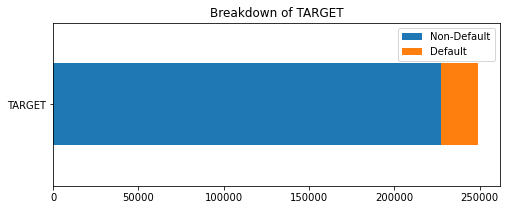

In [12]:
pd.DataFrame(df.TARGET.value_counts()).transpose().plot.barh(stacked = True, title = 'Breakdown of TARGET', figsize = (8,3))
plt.legend(['Non-Default', 'Default'])
plt.show()

As with majority of credit datasets, we can confirm that there is a class imbalance issue here that needs to be addressed going forward.

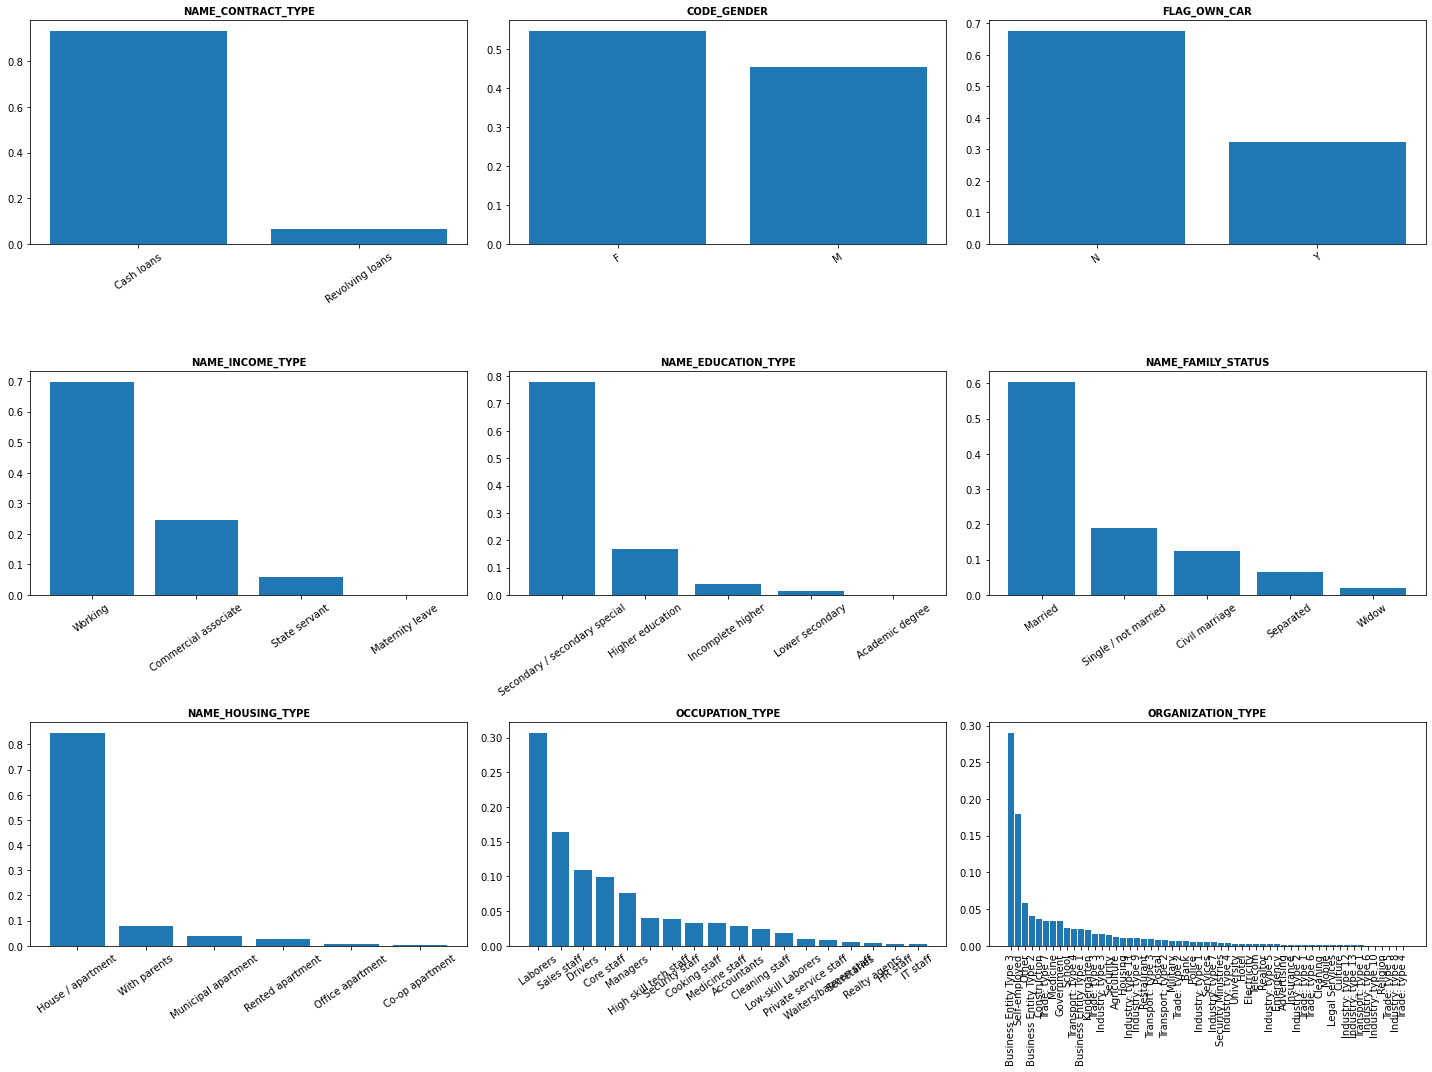

In [13]:
multiple = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 
            'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
            'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (20, 15))
count = 0

for row in range(len(axes)):
    for col in range(len(axes[0])):
        axes[row, col].bar(df[df.TARGET == 1][multiple[count]].value_counts(normalize = True).index,
                          df[df.TARGET == 1][multiple[count]].value_counts(normalize = True).values)
        axes[row, col].set_title(multiple[count], fontweight = 'bold', fontsize = 10)
        axes[row, col].tick_params(axis='x', rotation = 35)
        count += 1
# fig.suptitle('Default Cases Breakdown', fontsize = 18, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

Just looking that the above, there tend to be some interesting points to note including:
   - labourers tend to make up a high percentage in the occupation (high volatility within the job)
   - education wise, they tend to be within the secondary type

To better understand some of the key differences between those who defaulted and those who did not, lets visualize some of the key properties using a spider chart. That said, we need to get the data into the right format for the 'make_grouped_radar_chart' function, which can be found in the functions.py file.

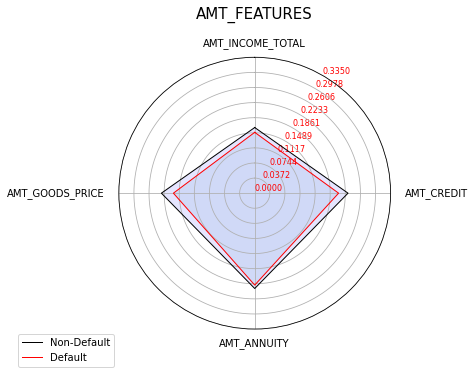

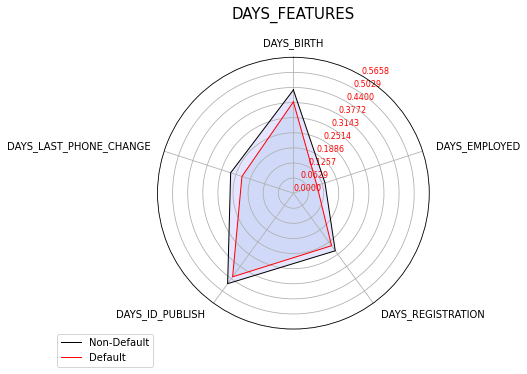

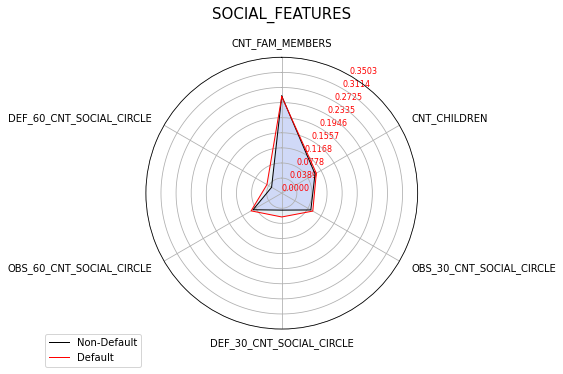

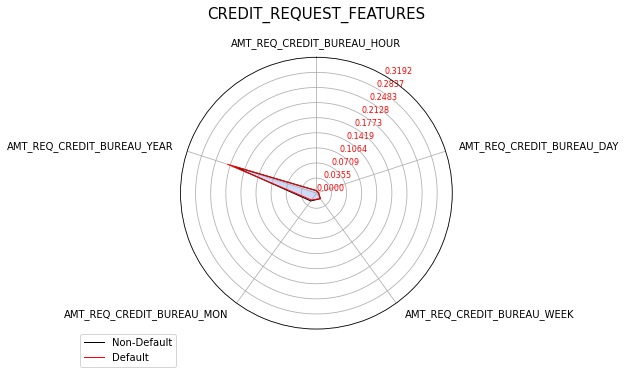

In [14]:
AMT_df = df[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]
DAYS_df = df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']]
SOCIAL_df = df[['CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']]
CREDIT_df = df[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR']]

spider_df = [AMT_df, DAYS_df, SOCIAL_df, CREDIT_df]
processed_spider_data = []

for dframe in spider_df:
    normalized = (dframe - dframe.min()) / (dframe.max() - dframe.min())
    concat = pd.concat([normalized, df.TARGET], axis = 1)
    processed_spider_data.append(concat.groupby('TARGET').mean())
    
# construct radar charts based on each factor outliend above
for data, label in zip(processed_spider_data, ['AMT_FEATURES', 'DAYS_FEATURES', 'SOCIAL_FEATURES', 'CREDIT_REQUEST_FEATURES']):
    make_radar_chart(data, label, (5, 5))    

Obviosly, whilst the charts above might visually imply something, there can be spurious correlations which may or may not happen by chance. As such, to narrow down the features, we need to conduct some statistical analysis as shown in the filter method discussed below.

# Feature Engineering

Let's explore two generic methods in
- Filter Method & Subject Matter Expertise. *This is generally used as a preprocessing step where selection of features is independent of any ML algorithms. Instead, features are selected based on the basis of their scores in various statistical tests*. 
    - Using subject matter expertise
    - Point Biserial Correlation (to compare dichotomous data to continuous data)
    - Chi-Square (for categorical data)
    - Variance Threshold (remove features with low variance)
- Wrapper Method. Use a subset of features and a train a model using them. Based on the inferences that we draw from previous model, we decide to add or remove features from the subset.
    - Stepwise Regression
    - Recursive Feature Elimination
    - Boruta package

#### Filter Method: Subject Matter Expertise
In this method, we add a few new features incorporating some of the common ratios that are used in the industry including:
   - Income / Credit Ratio (aka EARNINGS RATIO: measures repayment capability)
   - 1 - Credit / Goods Ratio (aka EQUITY CUSHION: measures how much equity (own cash) is used to purchase the goods)

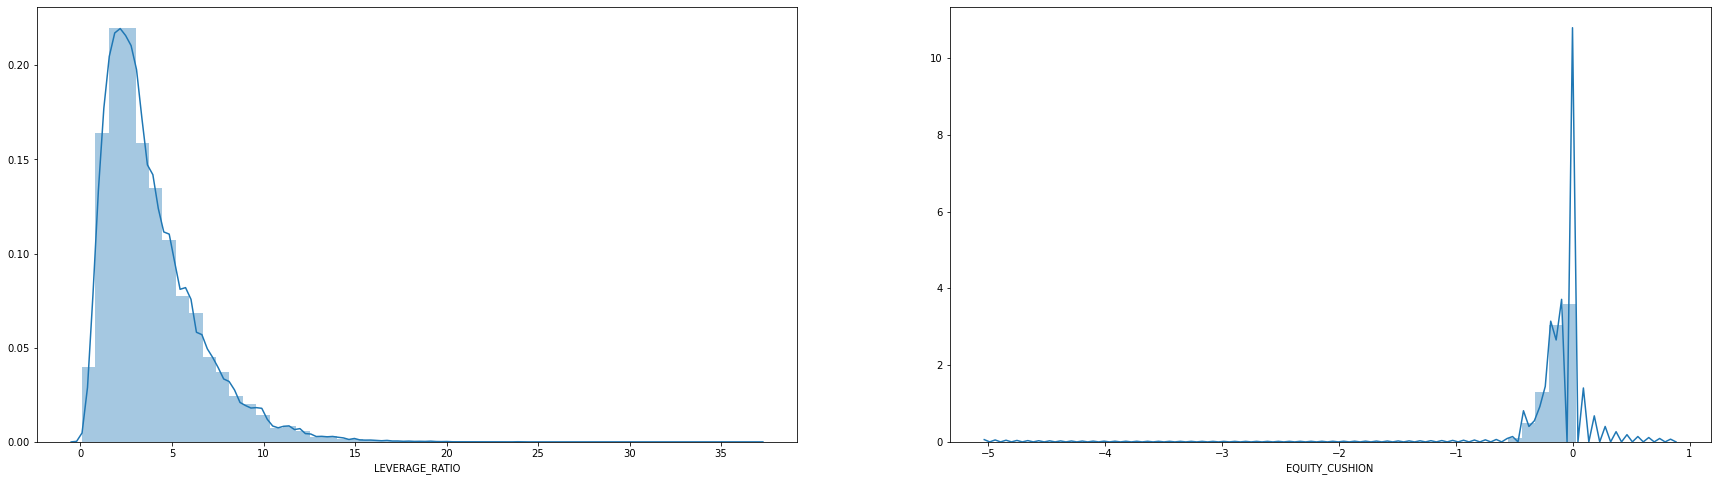

In [15]:
df['LEVERAGE_RATIO'] = df.AMT_CREDIT / df.AMT_INCOME_TOTAL
df['EQUITY_CUSHION'] = 1 - df.AMT_CREDIT / df.AMT_GOODS_PRICE

fig, ax = plt.subplots(1, 2, figsize = (30, 8))
sns.distplot(df.LEVERAGE_RATIO, ax = ax[0])
sns.distplot(df.EQUITY_CUSHION, ax = ax[1])
plt.show()

What we can see here is that borrowers tend to borrow multiple time of their income, with an average of 4x. Similarly for borrowers tend to borrow more than the required amount and as such put in less of their own money in purchasing the goods.

#### Filter Method: Point Biserial Correlation

Given the dichotomous nature of the target feature, alongside the some of the continuous features, it is best to use the point biserial correlation instead of Pearson's r in order to measure the strength of relationship between them

In [16]:
from scipy.stats import pointbiserialr

correlation = []
p_values = []
pbc_alpha = 0.001

for i in continuous_features:
    pbc = pointbiserialr(df.TARGET, df[i])
    correlation.append(pbc[0])
    p_values.append(pbc[1])
    
pbc_summary = pd.concat([pd.Series(correlation).rename('Correlation'), pd.Series(p_values).rename('P-values')], axis = 1)
pbc_summary.index = continuous_features
pbc_summary['Outcome'] = pbc_summary['P-values'].apply(lambda x: 'Reject' if x < pbc_alpha else 'Fail to Reject')
pbc_summary

,Correlation,P-values,Outcome
AMT_INCOME_TOTAL,-0.034,0.000,Reject
AMT_CREDIT,-0.040,0.000,Reject
AMT_ANNUITY,-0.018,0.000,Reject
AMT_GOODS_PRICE,-0.050,0.000,Reject
REGION_POPULATION_RELATIVE,-0.040,0.000,Reject
DAYS_BIRTH,-0.065,0.000,Reject
DAYS_EMPLOYED,-0.075,0.000,Reject
DAYS_REGISTRATION,-0.036,0.000,Reject
DAYS_ID_PUBLISH,-0.040,0.000,Reject
CNT_FAM_MEMBERS,-0.003,0.212,Fail to Reject


Here we can see 3 features that have been rejected, which if viewing it from a laymans perspective does seem to make sense.

#### Filter Method: Chi-Square Test

Now to gather signficance of categorical variables to the target variable, we run a Chi-Square test

In [17]:
from scipy.stats import chi2_contingency

categorical_col = [col for col in df.columns if (df[col].dtype == 'O') | ('FLAG' in col)]
stats = []
p_value = []
chi_alpha = 0.001

for col in categorical_col:
    # important to make sure the margin is false to ensure the correct degrees of freedom is calculated
    # dof calculated is as follows (r-1)(c-1) with r and c being rows and columns
    # chi-square = (O-E)^2 / E (sum of all boxes)
    crosstab = pd.crosstab(df.TARGET, df[col], margins = False)
    stat, p, dof, expected = chi2_contingency(crosstab)
    stats.append(stat), p_value.append(p)

chi2_summary = pd.concat([pd.Series(stats).rename('Stat'), pd.Series(p_value).rename('P-values')], axis = 1)
chi2_summary.index = categorical_col
chi2_summary['Outcome'] = chi2_summary['P-values'].apply(lambda x: 'Reject' if x < chi_alpha else 'Fail to Reject')
chi2_summary

,Stat,P-values,Outcome
NAME_CONTRACT_TYPE,326.162,0.000,Reject
CODE_GENDER,610.199,0.000,Reject
FLAG_OWN_CAR,247.368,0.000,Reject
FLAG_OWN_REALTY,2.012,0.156,Fail to Reject
NAME_TYPE_SUITE,37.284,0.000,Reject
NAME_INCOME_TYPE,518.084,0.000,Reject
NAME_EDUCATION_TYPE,"1,175.603",0.000,Reject
NAME_FAMILY_STATUS,393.449,0.000,Reject
NAME_HOUSING_TYPE,302.715,0.000,Reject
FLAG_MOBIL,2.154,0.142,Fail to Reject


#### Filter Method: Variance Threshold

Low variance features tend to not add much value and as such let's identify those features with low variances>

In [18]:
float_col = [col for col in df.columns if (df[col].dtype != 'O') & ('FLAG' not in col)]

from sklearn.feature_selection import VarianceThreshold

variance_threshold = 0.01

low_var_filter = VarianceThreshold(threshold = variance_threshold).fit(df[float_col])

low_var_cols = df[float_col].columns[low_var_filter.get_support() == False]
print ('Number of low variance features:', len(low_var_cols))
print ('Low variance features:', list(low_var_cols))

var = df[float_col].var().sort_values().to_frame()
var.columns = ['Variance']
var

Number of low variance features: 3
Low variance features: ['REGION_POPULATION_RELATIVE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY']


,Variance
REGION_POPULATION_RELATIVE,0.000
AMT_REQ_CREDIT_BUREAU_DAY,0.005
AMT_REQ_CREDIT_BUREAU_HOUR,0.006
EQUITY_CUSHION,0.017
REG_REGION_NOT_LIVE_REGION,0.017
EXT_SOURCE_3,0.031
AMT_REQ_CREDIT_BUREAU_WEEK,0.032
EXT_SOURCE_2,0.036
LIVE_REGION_NOT_WORK_REGION,0.047
REG_REGION_NOT_WORK_REGION,0.058


#### Filter Method Selected Features

Now we have examined some of the filter methods, we can now remove those non-relevant features to come up with a final set of features for modelling

In [19]:
to_remove = list(pbc_summary[pbc_summary.Outcome == 'Fail to Reject'].index) + list(chi2_summary[chi2_summary.Outcome == 'Fail to Reject'].index) + list(low_var_cols)
filter_features = [col for col in df.columns if col not in to_remove + ['TARGET']]
filter_df = df[filter_features]
filter_df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,LEVERAGE_RATIO,EQUITY_CUSHION
0,Cash loans,M,N,0,"202,500.000","406,597.500","24,700.500","351,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,"9,461.000",637.000,"3,648.000","2,120.000",0,1,Laborers,2,2,10,0,0,0,0,0,0,Business Entity Type 3,0.263,0.139,2.000,2.000,2.000,2.000,"1,134.000",1,0,0,0,0,0,0,0,0.000,1.000,2.008,-0.158
1,Cash loans,F,N,0,"270,000.000","1,293,502.500","35,698.500","1,129,500.000",Family,State servant,Higher education,Married,House / apartment,"16,765.000","1,188.000","1,186.000",291.000,0,1,Core staff,1,1,11,0,0,0,0,0,0,School,0.622,0.511,1.000,0.000,1.000,0.000,828.000,1,0,0,0,0,0,0,0,0.000,0.000,4.791,-0.145
2,Revolving loans,M,Y,0,"67,500.000","135,000.000","6,750.000","135,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,"19,046.000",225.000,"4,260.000","2,531.000",1,1,Laborers,2,2,9,0,0,0,0,0,0,Government,0.556,0.730,0.000,0.000,0.000,0.000,815.000,0,0,0,0,0,0,0,0,0.000,0.000,2.000,0.000
3,Cash loans,F,N,0,"135,000.000","312,682.500","29,686.500","297,000.000",Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,"19,005.000","3,039.000","9,833.000","2,437.000",0,0,Laborers,2,2,17,0,0,0,0,0,0,Business Entity Type 3,0.650,0.511,2.000,0.000,2.000,0.000,617.000,1,0,0,0,0,0,0,0,0.000,1.856,2.316,-0.053
4,Cash loans,M,N,0,"121,500.000","513,000.000","21,865.500","513,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,"19,932.000","3,038.000","4,311.000","3,458.000",0,0,Core staff,2,2,11,0,0,0,0,1,1,Religion,0.323,0.511,0.000,0.000,0.000,0.000,"1,106.000",0,0,1,0,0,0,0,0,0.000,0.000,4.222,0.000


### Pre-processing (Encoding)

Before we start to model, it is important to convert string columns into integers or floats.

In [20]:
from sklearn.preprocessing import LabelEncoder

binary = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR']
multiple = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE','NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

for col in binary:
    le = LabelEncoder()
    le.fit(filter_df[col].unique())
    filter_df[col] = le.transform(filter_df[col])
    
encoded = pd.get_dummies(filter_df[multiple])
processed_filter_df = pd.concat([filter_df, encoded], axis = 1)
processed_filter_df.drop(multiple, axis = 1, inplace = True)

### Under-Sampling to Solve for Imbalance Class Distribution

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

under_sampler = RandomUnderSampler()
X, y = under_sampler.fit_sample(processed_filter_df, df.TARGET)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1111)

X_norm = MinMaxScaler().fit_transform(X_train)
X_train_normed = pd.DataFrame(X_norm, columns = X_train.columns)

### Model 1: Logistic Regression with Filter Features

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:   50.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   57.6s finished


										**** BINARY CLASSIFICATION RESULTS SUMMARY ****
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
MODEL: Logistic Regression | DATASET: Train - MinMax Scaling | OUTCOME: Non-Default vs Default
TARGET DISTRIBUTION COUNT:
   Non-Default: 15134 / 0.500
   Default: 15150 / 0.500
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
5 FOLD CROSS-VALIDATION METRIC SCORES WITH MEAN: 

ACCURACY: [0.672 0.679 0.673 0.681 0.679] / 0.677
RECALL: [0.67  0.679 0.662 0.676 0.684] / 0.674
PRECISION: [0.673 0.679 0.677 0.684 0.678] / 0.678
F1: [0.672 0.679 0.67  0.68  0.681] / 0.676
SPECIFICITY: [0.674 0.679 0.684 0.687 0.674] / 0.680
-------------------------

                                                                                                                                                                                  SELECTED THRESHOLD: 0.42


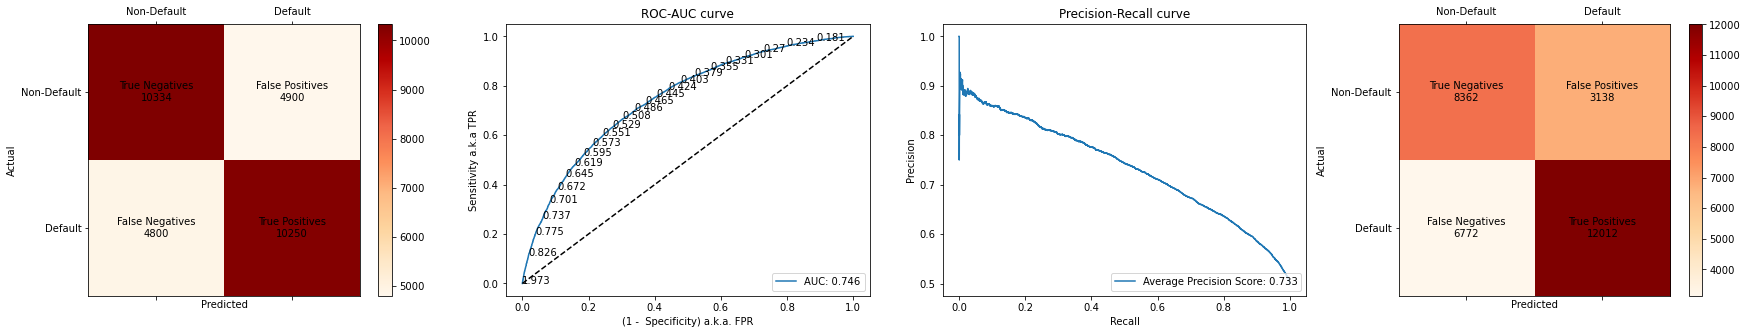

AUC GUIDELINES: [0.9 - 1.0 VERY GOOD | 0.8 - 0.9 G00D | 0.7 - 0.8 FAIR | 0.6 - 0.7 POOR | 0.5 - 0.6 FAIL]
GENERAL THRESHOLD GUIDELINES: [LOWER % LEADS TO BETTER RECALL & POORER SPECIFICITY | VICE VERSA]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
UPDATED METRICS USING SELECTED THRESHOLD OF 0.42 [SINGLE RUN]:

ACCURACY: 0.673 / DELTA: -0.004
RECALL: 0.793 / DELTA: 0.119
PRECISION: 0.639 / DELTA: -0.039
F1: 0.708 / DELTA: 0.032
SPECIFICITY: 0.553 / DELTA: -0.127
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
FEATURE IMPORTANCES:


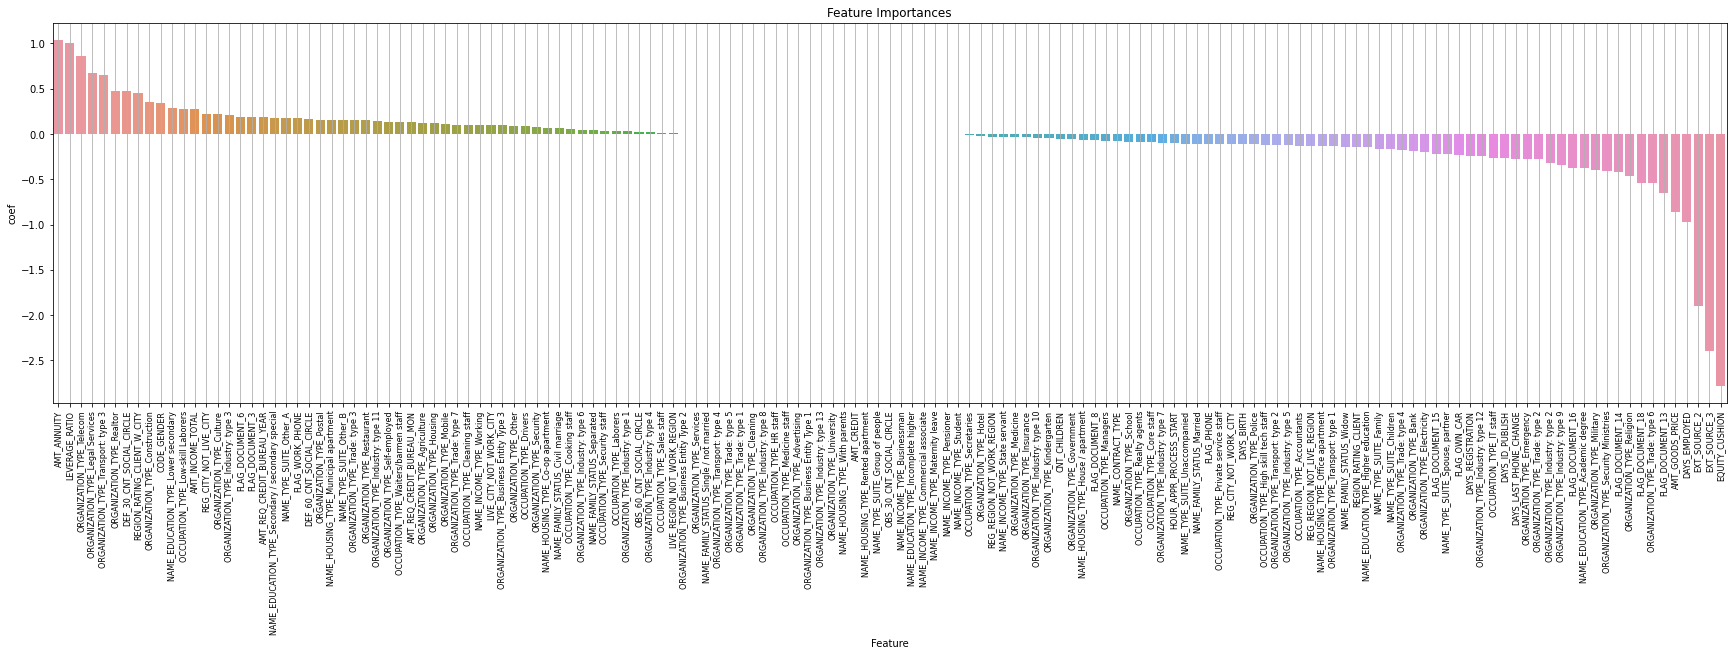

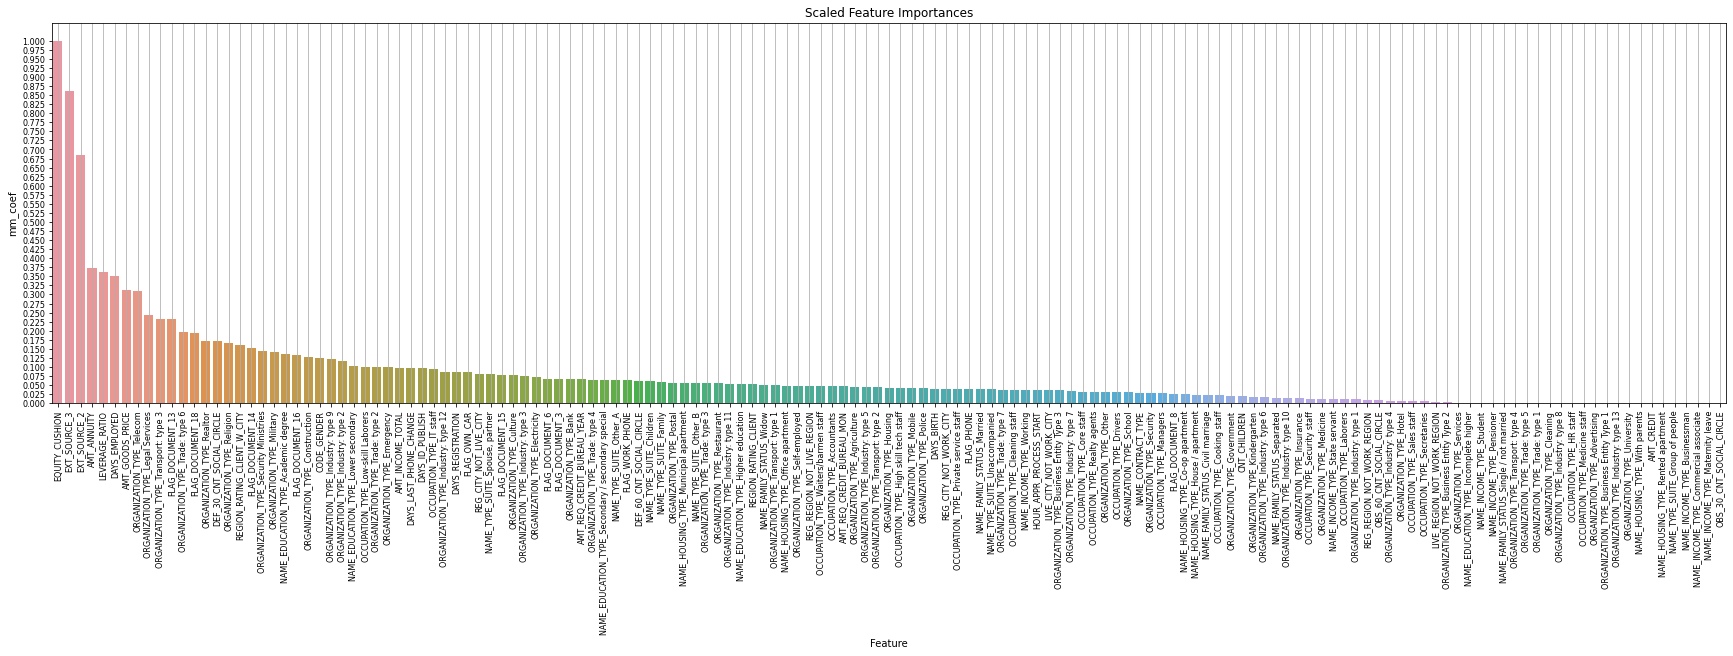

Select min-max coef. threshold: 0.025


Number of suggested features to remove: 48 

['NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_FAMILY_STATUS_Civil marriage', 'OCCUPATION_TYPE_Cooking staff', 'ORGANIZATION_TYPE_Government', 'CNT_CHILDREN', 'ORGANIZATION_TYPE_Kindergarten', 'ORGANIZATION_TYPE_Industry: type 6', 'NAME_FAMILY_STATUS_Separated', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Insurance', 'OCCUPATION_TYPE_Security staff', 'ORGANIZATION_TYPE_Medicine', 'NAME_INCOME_TYPE_State servant', 'OCCUPATION_TYPE_Laborers', 'ORGANIZATION_TYPE_Industry: type 1', 'REG_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE_Industry: type 4', 'ORGANIZATION_TYPE_Hotel', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries', 'LIVE_REGION_NOT_WORK_REGION', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Services', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Pensioner', 'NAME_FAMILY_STATUS_Single / not 

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

categories = ['Non-Default', 'Default']
# lasso with penalty
params_dist = {'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}

# ovr is for binary; one-versus-rest
lg = RandomizedSearchCV(LogisticRegression(penalty = 'l1', solver = 'saga', multi_class = 'ovr'), param_distributions = params_dist, n_iter = 50, cv = 5, verbose = 10, random_state = 42, n_jobs = -1).fit(X_train_normed, y_train)
binary_classification_summary('Logistic Regression', 'Train - MinMax Scaling', lg.best_estimator_, X_train_normed, y_train, categories)